In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
print(f"Parent directory: {parent_dir}")

Parent directory: /u/weim/lob


In [2]:
lots_list = [20, 60]
n_samples = 10000
train_iter = 400
tag = 'determinstic_action' 
batch_size= 12800

folder_path = f"{parent_dir}/rewards"
data = {}
agent_list = ['sl_agent', 'linear_sl_agent', 'log_normal_learn_std', 'log_normal']
for env in ['noise', 'flow', 'strategic']:
    data[env] = {}
    for lots in lots_list:
        data[env][lots] = {}
        for agent in agent_list:            
            try: 
                # rl strategies 
                if agent in ['log_normal']:               
                    name =  f'{folder_path}/{env}_{lots}_seed_0_eval_seed_100_eval_episodes_10000_num_iterations_{train_iter}_bsize_{batch_size}_{agent}_deterministic_action.npz'
                elif agent in ['log_normal_learn_std']:
                    name =  f'{folder_path}/{env}_{lots}_seed_0_eval_seed_100_eval_episodes_10000_num_iterations_{train_iter}_bsize_{batch_size}_{agent}.npz'
                    # name =  f'{folder_path}/{env}_{lots}_seed_0_eval_seed_100_eval_episodes_10000_num_iterations_{train_iter}_bsize_{batch_size}_{agent}_deterministic_action.npz'
                    # print(name)
                    # name = '/u/weim/lob/rewards/{env}_20_seed_0_eval_seed_100_eval_episodes_10000_num_iterations_400_bsize_12800_log_normal_learn_std_deterministic_action.npz'
                    # print(name)
                else:
                    # might need to updating the naming here
                    name = f'{folder_path}/{env}_{lots}_episodes_{10000}_eval_seed_100_{agent}.npz'                    
                print(f'loading from {name}')
                data[env][lots][agent] = np.load(name)['rewards']
            except:
                print(f"path doesnt exist: {name}")
                data[env][lots][agent] = 'no data aviailable'

loading from /u/weim/lob/rewards/noise_20_episodes_10000_eval_seed_100_sl_agent.npz
loading from /u/weim/lob/rewards/noise_20_episodes_10000_eval_seed_100_linear_sl_agent.npz
loading from /u/weim/lob/rewards/noise_20_seed_0_eval_seed_100_eval_episodes_10000_num_iterations_400_bsize_12800_log_normal_learn_std.npz
loading from /u/weim/lob/rewards/noise_20_seed_0_eval_seed_100_eval_episodes_10000_num_iterations_400_bsize_12800_log_normal_deterministic_action.npz
loading from /u/weim/lob/rewards/noise_60_episodes_10000_eval_seed_100_sl_agent.npz
loading from /u/weim/lob/rewards/noise_60_episodes_10000_eval_seed_100_linear_sl_agent.npz
loading from /u/weim/lob/rewards/noise_60_seed_0_eval_seed_100_eval_episodes_10000_num_iterations_400_bsize_12800_log_normal_learn_std.npz
loading from /u/weim/lob/rewards/noise_60_seed_0_eval_seed_100_eval_episodes_10000_num_iterations_400_bsize_12800_log_normal_deterministic_action.npz
loading from /u/weim/lob/rewards/flow_20_episodes_10000_eval_seed_100_sl

In [3]:
### this box is for learned variance strategies 

folder_path = f"{parent_dir}/latex_tables"
list_of_dfs = []
# n_lots = [20, 60]
# print(filler)
for env in ['noise', 'flow', 'strategic']:
    data_for_df = {}
    # agent_names = ['sl_agent', 'linear_sl_agent', 'dirichlet', 'log_normal']
    agent_names = ['sl_agent', 'linear_sl_agent', 'log_normal_learn_std', 'log_normal']
    name_dict = {'sl_agent': 'SL', 'linear_sl_agent': 'TWAP', 'dirichlet': 'DR', 'log_normal_learn_std': 'LNVR', 'log_normal': 'LN'}
    for agent in agent_names:
        print(agent)
        name = name_dict[agent]
        data_for_df[f'E[{name}]'] = []
        data_for_df[f'Std[{name}]'] = []
        for lots in lots_list:
            try:
                data_for_df[f'Std[{name}]'] += [np.std(data[env][lots][agent])]
                data_for_df[f'E[{name}]'] += [np.mean(data[env][lots][agent])]                
            except:
                print(f"no data available for {env}, {lots}, {agent}")
                data_for_df[f'Std[{name}]'] += [np.nan]
                data_for_df[f'E[{name}]'] += [np.nan]
    df = pd.DataFrame.from_dict(data_for_df).round(2)    
    df.index.name = 'Lots'
    index_name = [f'{env}_{l}' for l in lots_list]
    df.index = index_name
    df = df.round(2)
    list_of_dfs.append(df)

complete_df = pd.concat(list_of_dfs, axis=0)
print(complete_df)


highest_exp = []
lowest_std = []
for idx in complete_df.index:
    expected_values = complete_df.loc[idx, ['E[SL]', 'E[TWAP]', 'E[LNVR]', 'E[LN]']]
    max_idx = expected_values.idxmax()
    highest_exp.append((idx, max_idx))
    std_values = complete_df.loc[idx, ['Std[SL]', 'Std[TWAP]', 'Std[LNVR]', 'Std[LN]']]
    min_idx = std_values.idxmin()
    lowest_std.append((idx, min_idx))

complete_df = complete_df.astype(str)
for idx, max_idx in highest_exp:
    complete_df.loc[idx, max_idx] = fr"\textbf{{{complete_df.loc[idx, max_idx]}}}"

# dont highlight std for now
# for idx, min_idx in lowest_std:
#     complete_df.loc[idx, min_idx] = fr"\textbf{{{complete_df.loc[idx, min_idx]}}}"

complete_df = complete_df.drop(['noise', 'flow', 'strategic'], errors='ignore')
complete_df.insert(0, r'\#Lots', complete_df.index.astype(str))
complete_df.iloc[:,0] = [20,60]*3

complete_df.insert(0, r'Market', complete_df.index.astype(str))
complete_df.iloc[:,0] = ['Noise', '', 'Noise \& Tactical', '', 'Noise \& Tactical', '\& Strategic']

rename_dict = {'E[SL]': r'$\mathbb{E}[\text{SL}]$', 'Std[SL]': r'$\sigma[\text{SL}]$', 
               'E[TWAP]': r'$\mathbb{E}[\text{TWAP}]$', 'Std[TWAP]': r'$\sigma[\text{TWAP}]$', 
               'E[LN]': r'$\mathbb{E}[\text{LN}]$', 'Std[LN]': r'$\sigma[\text{LN}]$', 
            #    'E[DR]': r'$\mathbb{E}[\text{DR}]$', 'Std[DR]': r'$\sigma[\text{DR}]$',
               'E[LNVAR]': r'$\mathbb{E}[\text{LNVAR}]$', 'Std[LNVAR]': r'$\sigma[\text{LNVAR}]$'
               }
print(complete_df)
complete_df = complete_df.rename(columns=rename_dict)
complete_df = complete_df.where(pd.notnull(complete_df), '')

latex_table = complete_df.to_latex(float_format="%.2f", index=False, column_format='l'+'c'*9, escape=False)
saving_path = f"{folder_path}/results_table_latest_with_dirichlet_{tag}.tex" if tag is not None else f"{folder_path}/results_table_latest_with_dirichlet.tex"
tag = 'learned_variance'
saving_path = f"{folder_path}/results_table_log_normal_deterministic_action_{tag}.tex" 
tag = '' if tag is None else tag
with open(saving_path, "w") as f:
    content = (
        r"\begin{table}[htpb]"+
        r"\label{table:" + tag +"}"+
        r"\begin{center}"+
        r"    \begin{scriptsize}"+
        r"        \begin{sc}"
        + latex_table +
        r"        \end{sc}"+
        r"    \end{scriptsize}"+
        r"\end{center}"+
        r"\end{table}"        
    )
    f.write(content)


sl_agent
linear_sl_agent
log_normal_learn_std
log_normal
sl_agent
linear_sl_agent
log_normal_learn_std
log_normal
sl_agent
linear_sl_agent
log_normal_learn_std
log_normal
              E[SL]  Std[SL]  E[TWAP]  Std[TWAP]  E[LNVR]  Std[LNVR]  E[LN]  \
noise_20       0.52     1.19    -0.06       0.94     0.64       0.93   0.61   
noise_60      -1.09     1.34    -1.40       0.98    -0.77       0.99  -0.72   
flow_20        0.10     1.43     0.48       0.68     0.74       0.70   0.81   
flow_60       -3.36     0.99    -0.96       0.95    -0.41       0.69  -0.25   
strategic_20  -1.64     2.95    -0.36       3.03     1.15       2.14   1.13   
strategic_60  -2.51     3.67    -1.45       3.46     0.14       2.04   0.23   

              Std[LN]  
noise_20         1.03  
noise_60         0.90  
flow_20          0.64  
flow_60          0.67  
strategic_20     2.08  
strategic_60     2.15  
                         Market \#Lots  E[SL] Std[SL] E[TWAP] Std[TWAP]  \
noise_20                  Noise 

#############
generating plots for  noise
saving to /u/weim/lob/plots/reward_distribution_noise_learned_variance.pdf
#############
generating plots for  flow
saving to /u/weim/lob/plots/reward_distribution_flow_learned_variance.pdf
#############
generating plots for  strategic
saving to /u/weim/lob/plots/reward_distribution_strategic_learned_variance.pdf


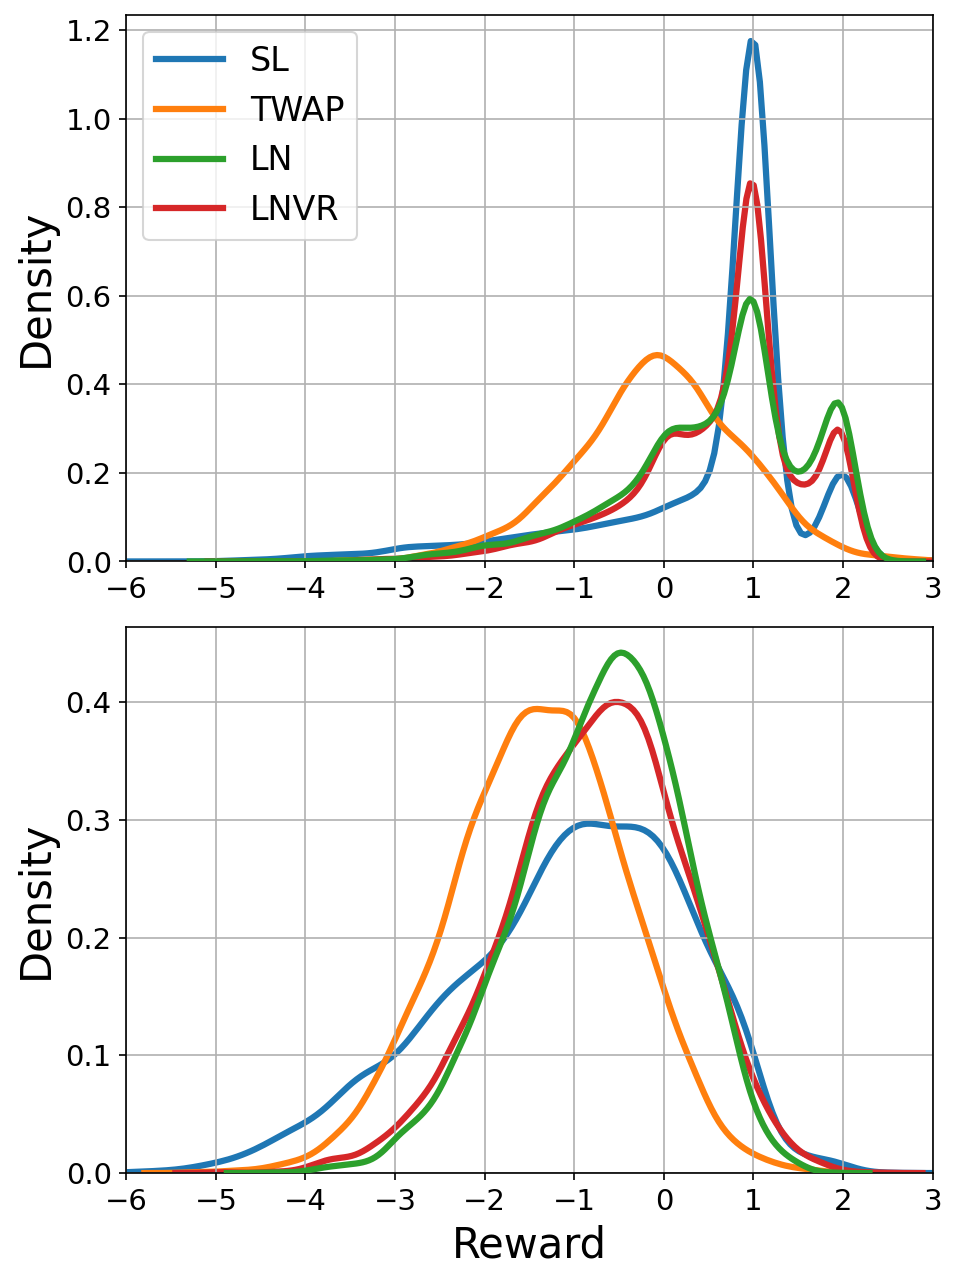

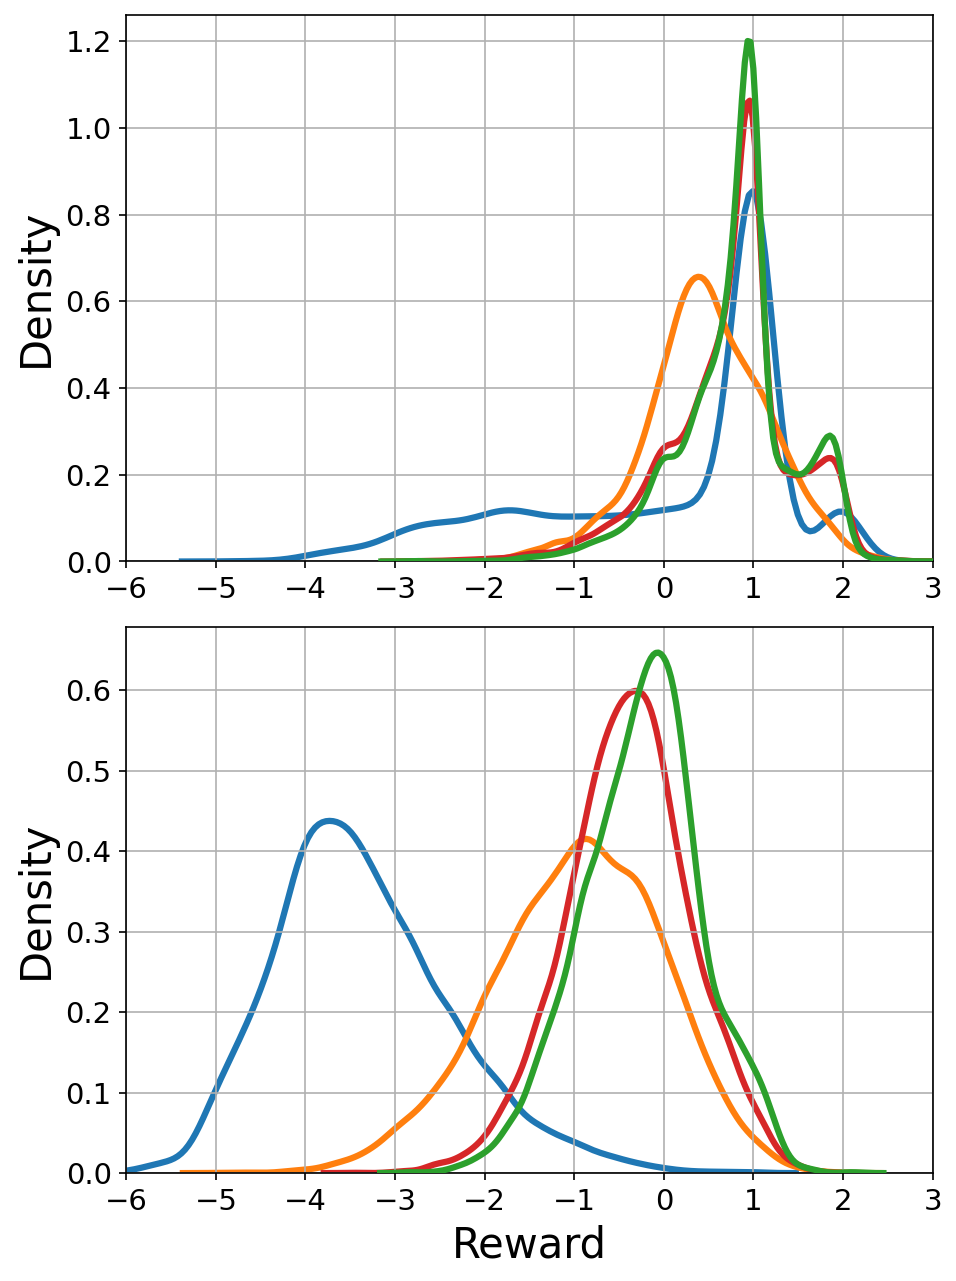

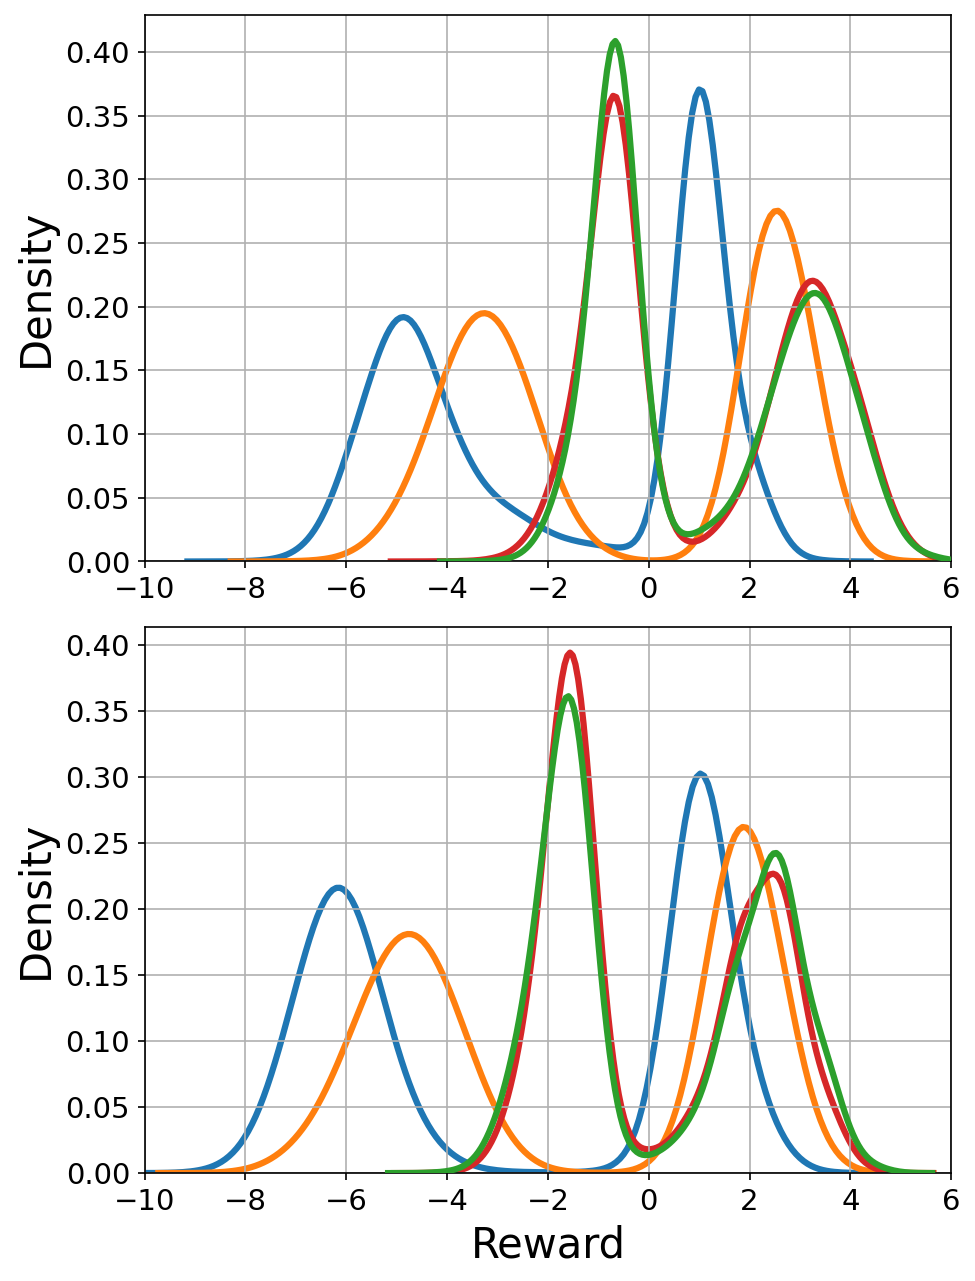

In [4]:
### density plot for deterministic actions 

lots_list = [20, 60]
textwidth = 6.75
textheight = 9
scale = 3.2

agent_names = ['sl_agent', 'linear_sl_agent', 'log_normal', 'log_normal_learn_std']
# without dirichlet
# this yields the correct ordering in the maps 
# agent_names = ['sl_agent', 'linear_sl_agent',  'log_normal', 'log_normal_learn_std']
# agent_names = ['sl_agent', 'linear_sl_agent', 'log_normal']
# agent_names = ['log_normal', 'sl_agent', 'linear_sl_agent']
for i, env in enumerate(['noise', 'flow', 'strategic']):
    print('#############')
    print('generating plots for ', env)
    fig, axs = plt.subplots(2, 1, figsize=(scale*0.3*textwidth, scale*0.3*textheight), dpi=300)
    for j, lots in enumerate(lots_list):
        ax = axs[j]
        for agent in agent_names:
            # names = {'sl_agent': 'SL', 'linear_sl_agent': 'TWAP', 'actor_critic': 'RL'} 
            name_translation = {'sl_agent': 'SL', 'linear_sl_agent': 'TWAP', 'log_normal': 'LN', 'dirichlet': 'DR', 'log_normal_learn_std': 'LNVR'}
            try: 
                if agent == 'log_normal':
                    z_order = 10
                else:
                    z_order = 1 
                sns.kdeplot(data[env][lots][agent], fill=False, label=name_translation[agent], bw_adjust=1, linewidth=3, ax=ax, zorder=z_order)
            except: 
                print(f"no data available for {env}, {lots}, {agent}")
        if env == 'noise' and lots == 20:   
            ax.legend(prop={'size': 16}, loc='upper left')
        # set legend at the top of ech market. can comment this out if necessary. 
        # if j == 0:
            # ax.legend(prop={'size': 16}, loc='upper left')  
        fig.set_dpi(150)
        if j == 1:
            ax.set_xlabel('Reward', fontsize=20)
            # ax.set_xlabel('X', fontsize=20)
        # ax.set_title(f'{env}', fontsize=18)
        if i == 0:
            ax.set_ylabel('Density', fontsize=20)
        else:
            ax.set_ylabel('')
        # set density label everywhere
        # comment out if necessary 
        ax.set_ylabel('Density', fontsize=20)
        # if i == 0:
            # ax.set_title(f'Noise', fontsize=18)
        # if j == 0:
        # ax.set_title(f'#Lots={n_lots}', fontsize=18)
        tick_size = 14
        ax.tick_params(axis='x', labelsize=tick_size)
        ax.tick_params(axis='y', labelsize=tick_size)
        ax.grid()
        ax.set_xticks(np.arange(-10, 10, 1))
        if env == 'flow':
            ax.set_xlim(-6, 3)
        elif env == 'strategic':
            ax.set_xticks(np.arange(-12, 12, 2))
            ax.set_xlim(-10, 6)
        else:
            # adjust xlim depending on experiments manually 
            ax.set_xlim(-6, 3)
    plt.tight_layout() 
    tag = 'learned_variance'
    name = f'{parent_dir}/plots/reward_distribution_{env}_{tag}.pdf'
    print(f'saving to {name}')
    plt.savefig(name)
